## Setup

In [2]:
!pip install smdebug torch torchvision tqdm boto3
!pip install autogluon --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 3.5 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
# Import
import numpy as np
import pandas as pd
import os
import boto3
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
import sagemaker
session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = session.boto_region_name
bucket = 's3://old-man-mcbucket'
os.environ["DEFAULT_S3_BUCKET"] = bucket

## Data Loading and Preprocessing

In [ ]:
# Download data from S3

sagemaker.s3.S3Downloader.download(
    s3_uri=os.path.join(bucket, 'data'),
    local_path='data',
    sagemaker_session=session)

In [2]:
# load into dataframes
df_users = pd.read_json('data/profile.json', lines=True)
df_portfolio = pd.read_json('data/portfolio.json', lines=True)
df_transcript = pd.read_json('data/transcript.json', lines=True)

In [3]:
df_users['became_member_on'] = pd.to_datetime(df_users['became_member_on'], format='%Y%m%d')
df_users.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [4]:
channels = set(df_portfolio['channels'].sum())
for channel in channels:
    df_portfolio[f'is_{channel}'] = df_portfolio['channels'].apply(lambda x: channel in x)
df_portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,is_web,is_email,is_mobile,is_social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,False,True,True,True
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True,True,True
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,True,True,True,False
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True,False
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,True,False,False


In [5]:
# extract relevant parameters from the value column
def extract_offer_id(x):
    val = x.get('offer id')
    if val is not None:
        return val
    else:
        val = x.get('offer_id')
        return val

df_transcript['offer_id'] = df_transcript['value'].apply(lambda x: extract_offer_id(x))
df_transcript['transaction_amount'] = df_transcript['value'].apply(lambda x: x.get('amount'))
df_transcript['offer_value'] = df_transcript['value'].apply(lambda x: x.get('reward'))
df_transcript.head()

,person,event,value,time,offer_id,transaction_amount,offer_value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


## Data Cleaning and Preprocessing

### User data

In [6]:
df_users[df_users.isnull().any(axis=1)]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN


In [7]:
### Remove null values from dataset
print('Initial shape:', df_users.shape)
df_users.isnull().sum()
df_users.dropna(subset='gender', inplace=True)
df_users = df_users[df_users['age'] != 118]
print('Final shape:', df_users.shape)

Initial shape: (17000, 5)
Final shape: (14825, 5)


## Data Exploration

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

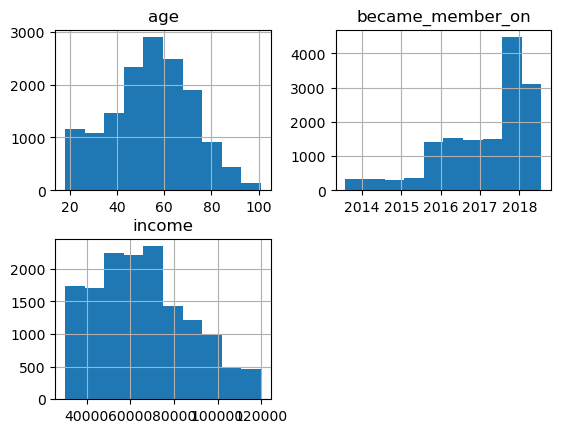

In [8]:
df_users.hist()

# Age is fairly balanced
# Most users signed up in 2017
# Income is right-skewed

In [9]:
df_users.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


In [10]:
# Compute a propensity score for each user
# propensity = # of completed offers / # of viewed offers
# propensity must be between 0 and 1
# if propensity exceeds 1, then it means that users completed offers without viewing them

df_transcript['is_transaction'] = df_transcript['event'] == 'transaction'
df_transcript['is_completed'] = df_transcript['event'] == 'offer completed'
df_transcript['is_viewed'] = df_transcript['event'] == 'offer viewed'
df_transcript['is_received'] = df_transcript['event'] == 'offer received'
df_transcript['offer_id'].fillna('n/a', inplace=True)

user_agg = df_transcript.groupby(['person', 'offer_id'])[['is_received', 'is_viewed', 'is_completed', 'is_transaction']].sum()
user_agg['propensity'] = user_agg['is_completed'] / user_agg['is_viewed']
user_agg['completed without viewing'] = (user_agg['is_completed'] - user_agg['is_viewed']).apply(lambda x: max(0, x))

### Influenced Transaction Breakdown

How do influenced/non-influenced transactions compare?

In [11]:
# which transactions were influenced? Which were not?

def is_influenced_transaction(row):
    if row['offer_id'] != row['offer_id']:
        return False
    if row['time difference'] > row['duration'] * 24:
        return False
    if row['transaction_amount'] < row['difficulty']:
        return False
    return True

transactions = df_transcript[df_transcript['event'] == 'transaction'][['person', 'event', 'time', 'transaction_amount']]
transactions['transaction_id'] = transactions.index + 1
viewed_offers = df_transcript[df_transcript['event'] == 'offer viewed'][['person', 'event', 'time', 'offer_id']]

# which transactions were influenced by offers?
influenced_transactions = pd.merge(viewed_offers, transactions, on = ['person'], how = 'right', suffixes=('_x', '_y'))
influenced_transactions['time_x'].fillna(-1, inplace=True)
influenced_transactions['time difference'] = influenced_transactions['time_y'] - influenced_transactions['time_x']

# only consider offers that came before transactions
influenced_transactions = influenced_transactions[influenced_transactions['time difference'] >= 0]
influenced_transactions = pd.merge(df_portfolio, influenced_transactions, how='right', left_on='id', right_on='offer_id', suffixes=('_a', '_b'))
influenced_transactions['is_influenced'] = influenced_transactions.apply(lambda x: is_influenced_transaction(x), axis=1)

# remove replicate entries
influenced_transactions = influenced_transactions.sort_values(by='is_influenced', ascending=False).drop_duplicates(subset='transaction_id', keep='first')

# separate influenced and organic transactions into different columns
influenced_transactions['influenced_transaction_amount'] = influenced_transactions['transaction_amount'] * influenced_transactions['is_influenced']
influenced_transactions['organic_transaction_amount'] = influenced_transactions['transaction_amount'] * (1 - influenced_transactions['is_influenced'])
influenced_transactions['influenced_transaction_amount'].replace(0, np.nan, inplace=True)
influenced_transactions['organic_transaction_amount'].replace(0, np.nan, inplace=True)

influenced_transactions.head()

,reward,channels,difficulty,duration,offer_type,id,is_web,is_email,is_mobile,is_social,...,time_x,offer_id,event_y,time_y,transaction_amount,transaction_id,time difference,is_influenced,influenced_transaction_amount,organic_transaction_amount
143132,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,True,True,True,False,...,444.0,2906b810c7d4411798c6938adc9daaa5,transaction,516,16.22,223331,72.0,True,16.22,NaN
227519,2.0,"[web, email, mobile, social]",10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,True,True,True,True,...,576.0,fafdcd668e3743c1bb461111dcafc2a4,transaction,630,19.97,285074,54.0,True,19.97,NaN
227718,0.0,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,False,True,True,True,...,630.0,5a8bc65990b245e5a138643cd4eb9837,transaction,630,15.67,285162,0.0,True,15.67,NaN
90474,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,True,True,True,False,...,408.0,2906b810c7d4411798c6938adc9daaa5,transaction,420,18.32,173018,12.0,True,18.32,NaN
227723,2.0,"[web, email, mobile, social]",10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,True,True,True,True,...,504.0,fafdcd668e3743c1bb461111dcafc2a4,transaction,630,11.46,285165,126.0,True,11.46,NaN


In [12]:
# If we ignore dust transactions, then influenced transactions are worth roughly as much as organic transactions

influenced_transactions[influenced_transactions['transaction_amount'] < 0.5].groupby(['is_influenced'])[['transaction_amount']].agg([np.mean, np.median, np.sum, 'count'])

transaction_amount                      
                            mean median      sum count
is_influenced                                         
False                   0.271915   0.28  1245.10  4579
True                    0.267490   0.27   137.49   514

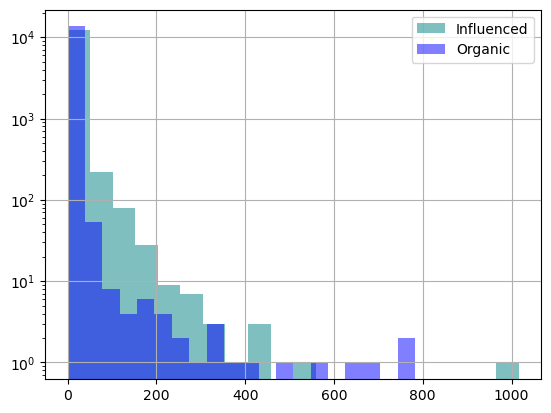

In [13]:
transaction_data = influenced_transactions.groupby(['person', 'is_influenced'])['transaction_amount'].agg([np.mean, np.sum, np.median, 'count'])
transaction_data = transaction_data.reset_index()[['is_influenced', 'count', 'mean']]

transaction_data[transaction_data['is_influenced'] == True]['mean'].hist(color = 'teal', bins=20, alpha = 0.5, log=True, label='Influenced')
transaction_data[transaction_data['is_influenced'] == False]['mean'].hist(color = 'blue', bins=20, alpha = 0.5, log=True, label='Organic')
plt.legend()

# Higher distribution for influenced purchases compared to non-influenced purchases

Text(0, 0.5, 'Transaction Count')

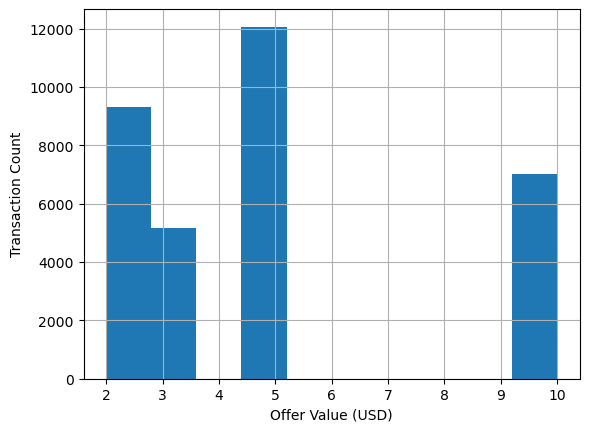

In [14]:
# Distribution of reward values

completed_offers = df_transcript[df_transcript['event'] == 'offer completed']
completed_offers['offer_value'].hist()
plt.xlabel('Offer Value (USD)')
plt.ylabel('Transaction Count')

### Offer Types

In [15]:
# Aggeregate by offer type
offer_status = user_agg.reset_index().groupby('offer_id')[['is_received', 'is_viewed', 'is_completed', 'completed without viewing']].sum()
offer_status_details = offer_status.merge(df_portfolio, left_index=True, right_on = 'id')
offer_status_details['proportion not viewed'] = offer_status_details['completed without viewing'] / offer_status_details['is_completed']
offer_status_details['view rate'] = offer_status_details['is_viewed'] / offer_status_details['is_received']
offer_status_details['completion rate'] = offer_status_details['is_completed'] / offer_status_details['is_received']

offer_status_details

,is_received,is_viewed,is_completed,completed without viewing,reward,channels,difficulty,duration,offer_type,id,is_web,is_email,is_mobile,is_social,proportion not viewed,view rate,completion rate
4,7668,2663,3420,1820,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,True,False,False,0.532164,0.347287,0.446009
5,7646,7337,5156,156,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,True,True,True,True,0.030256,0.959587,0.674340
9,7632,4118,4017,1322,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,True,True,True,False,0.329101,0.539570,0.526336
2,7617,4144,0,0,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,True,True,True,False,NaN,0.544046,0.000000
1,7593,7298,3331,84,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True,True,True,0.025218,0.961148,0.438694
7,7618,6687,0,0,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,False,True,True,True,NaN,0.877789,0.000000
3,7677,4171,4354,1574,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True,False,0.361507,0.543311,0.567149
0,7658,6716,3688,415,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,False,True,True,True,0.112527,0.876991,0.481588
8,7571,7264,4296,120,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,True,True,True,True,0.027933,0.959451,0.567428
6,7597,7327,5317,138,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,True,True,True,True,0.025954,0.964460,0.699882


In [32]:
offer_status_compiled = offer_status_details.groupby('offer_type').sum()
offer_status_compiled['proportion not viewed'] = offer_status_compiled['completed without viewing'] / offer_status_compiled['is_completed']
offer_status_compiled['view rate'] = offer_status_compiled['is_viewed'] / offer_status_compiled['is_received']
offer_status_compiled['completion rate'] = offer_status_compiled['is_completed'] / offer_status_compiled['is_received']

offer_status_compiled

,is_received,is_viewed,is_completed,completed without viewing,reward,difficulty,duration,is_email,is_social,is_mobile,is_web,proportion not viewed,view rate,completion rate
offer_type,,,,,,,,,,,,,,
bogo,30499,25449,15669,2193,30,30,24,4,3,4,3,0.139958,0.834421,0.513755
discount,30543,21445,17910,3436,12,47,34,4,2,3,4,0.191848,0.702125,0.586386
informational,15235,10831,0,0,0,0,7,2,1,2,1,NaN,0.710929,0.000000


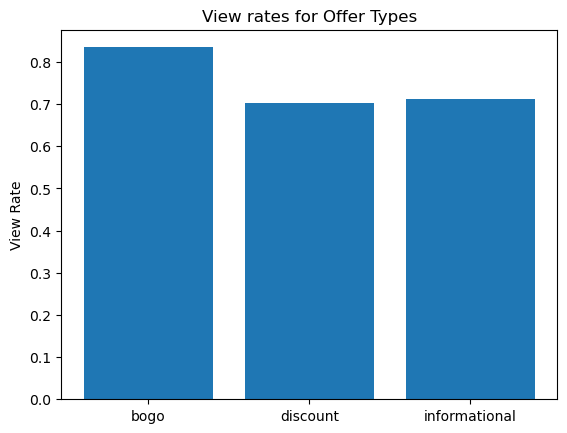

In [33]:
plt.bar(offer_status_compiled.index, offer_status_compiled['view rate'])
plt.title('View rates for Offer Types')
plt.ylabel('View Rate')
# BOGO seems to have an overall higher view rate compared to the other offers
plt.savefig('img/view rates.png')

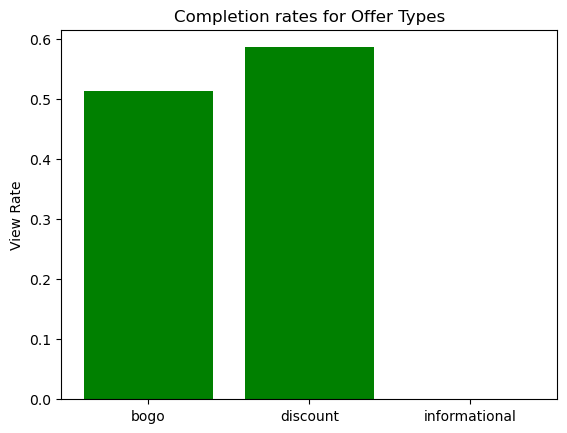

In [35]:
plt.bar(offer_status_compiled.index, offer_status_compiled['completion rate'], color='g')
plt.title('Completion rates for Offer Types')
plt.ylabel('View Rate')

# Discount has a higher completion rate in comparison
plt.savefig('img/completion rates.png')

## Data Transformation + Feature Engineering

Input data = combination of user profile + offer  
output = probability of engagement


In [36]:
# Engineering features from users
df_users['month_signup'] = df_users['became_member_on'].dt.month
df_users['year_signup'] = df_users['became_member_on'].dt.year
df_users['day_signup'] = df_users['became_member_on'].dt.day

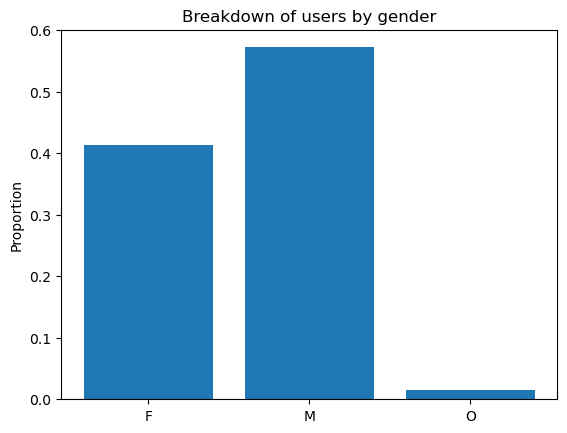

In [37]:
axis = 'gender'

proportions = df_users.groupby(axis).count() / df_users.shape[0]

plt.bar(proportions.index, proportions['age'])
plt.title(f'Breakdown of users by {axis}')
plt.ylabel('Proportion')

# Majority of users are male
plt.savefig('img/gender.png')

In [39]:
# reduce to useful features

user_features = ['gender', 'age', 'income', 'month_signup', 'year_signup', 'day_signup']
offer_features = ['is_web', 'is_social', 'is_email', 'is_mobile', 'reward', 'difficulty', 'duration', 'offer_type']

# if user completed no offers without viewing beforehand then they are not influenced for the sake of this model
target_value = user_agg['propensity'].apply(lambda x: 0 if x > 1000 else max(0, min(1, x))).reset_index()
target_value.fillna(0, inplace=True)

df_users['key'] = 1
df_users['person'] = df_users['id']
df_portfolio['key'] = 1
df_portfolio['offer_id'] = df_portfolio['id']

final_df = pd.merge(
    target_value,
    pd.merge(df_users, df_portfolio, on='key', how='inner'),
    on=['person', 'offer_id'], how='inner'
)

final_df = final_df[['propensity'] + user_features + offer_features]
final_df = pd.get_dummies(final_df)

In [40]:
final_df.to_csv('final_data.csv')

In [16]:
final_df = pd.read_csv('final_data.csv', index_col=0)

final_df.shape

(55222, 19)

Text(0, 0.5, 'User Count')

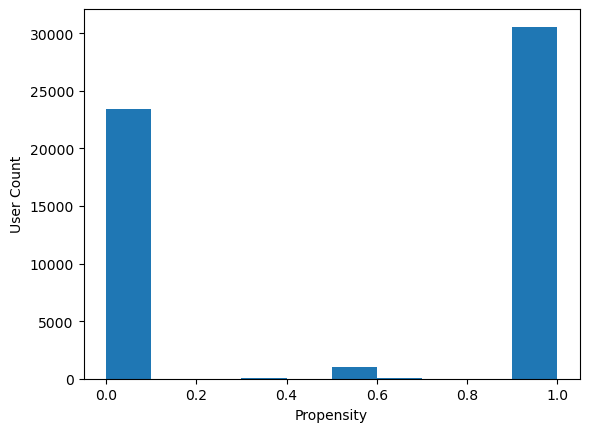

In [17]:
plt.hist(final_df['propensity'])
plt.xlabel('Propensity')
plt.ylabel('User Count')

# Some users in between, but vast majority of instances are binary
plt.savefig('img/labels.png')

In [18]:
final_df['propensity'] = final_df['propensity'].round(0)

In [19]:
final_df.groupby('propensity')['age'].count() / final_df['propensity'].shape[0]
# Slight bias towards the positive class, but otherwise not enough to raise flags about imbalanced data

propensity
0.0    0.445112
1.0    0.554888
Name: age, dtype: float64

## Model setup

The objective is to predict the likelihood that a user will engage with a promotional offer and complete a transaction with it.

This can be useful for:
- A) testing out new offers; we can better understand what types of campaigns drive the most engagement
- B) prioritizing resources for campaigns.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

train_data, test_data = train_test_split(final_df, test_size=0.2)
# validation_data, test_data = train_test_split(test_data, test_size=0.5)

print(f'Train:{train_data.shape[0]}')
# print(f'Validation:{validation_data.shape[0]}')
print(f'Test:{test_data.shape[0]}')

Train:44177
Test:11045


### Baseline Model

In [21]:
# Baseline logistic regression model
from sklearn.linear_model import LogisticRegression

test_x = test_data[[x for x in test_data.columns if x != 'propensity']]
test_y = test_data['propensity']

baseline = LogisticRegression()
baseline.fit(train_data[[x for x in train_data.columns if x != 'propensity']], train_data['propensity'])

predictions = baseline.predict(test_x)
print('f1:', metrics.f1_score(test_y, predictions))
print('accuracy:', metrics.accuracy_score(test_y, predictions))
print('precision:', metrics.precision_score(test_y, predictions))
print('recall:', metrics.recall_score(test_y, predictions))

f1: 0.7068445975032286
accuracy: 0.6300588501584428
precision: 0.6289581205311542
precision: 0.8067474615132656


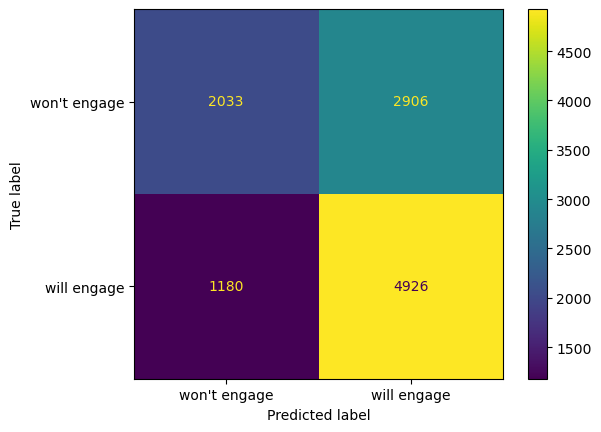

In [22]:
# confusion matrix
cm = metrics.confusion_matrix(test_y, baseline.predict(test_x))

metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['won\'t engage', 'will engage']
).plot()

# Model is more prone to false positives than false negatives.
# This is desirable because we want to cast a wide net with these offers in order.

plt.savefig('img/baseline_cm.png')

### Autogluon Model

In [ ]:
# Autogluon automates a lot of the model selection, so we can use that in lieu of pulling individual models from SKLearn
from autogluon.tabular import TabularPredictor

# load existing model
# predictor = TabularPredictor.load("AutogluonModels/ag-20230220_023906/")

predictor = TabularPredictor(
    label='propensity', eval_metric='f1',
    problem_type='binary',
).fit(final_df, time_limit=300,
      presets='best_quality',
      excluded_model_types=['NeuralNetFastAI_BAG_L1', 'NN']  # issues with building MXNet locally
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230220_070147/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20230220_070147/"
AutoGluon Version:  0.6.2
Python Version:     3.9.13
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 22.2.0: Fri Nov 11 02:08:47 PST 2022; root:xnu-8792.61.2~4/RELEASE_X86_64
Train Data Rows:    55222
Train Data Columns: 18
Label Column: propensity
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    13045.08 MB
	Train Data (Original)  Memory Usage: 6.41 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_

In [ ]:
predictor.fit_summary()

In [ ]:
predictions = predictor.predict_proba(test_data)
fpr, tpr, thresholds = metrics.roc_curve(test_y, predictions[1], pos_label=1)
plt.plot(fpr, tpr, 'b', label='Autogluon')

predictions_baseline = baseline.predict_proba(test_x)
fpr, tpr, thresholds = metrics.roc_curve(test_y, predictions_baseline[:,1], pos_label=1)
plt.plot(fpr, tpr, 'g', label='Logistic Regression')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model Performance')
plt.legend()
plt.savefig('img/roc/png')

In [ ]:
# confusion matrix
cm = metrics.confusion_matrix(test_data['propensity'], predictions[1] > 0.5)

metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['won\'t engage', 'will engage']
).plot()

# Model is more prone to false positives than false negatives.
# This is desirable because we want to cast a wide net with these offers in order.

plt.savefig('img/ag_cm.png')

In [289]:
predictions = predictor.predict(test_data)
print('f1:', metrics.f1_score(test_y, predictions))
print('accuracy:', metrics.accuracy_score(test_y, predictions))
print('precision:', metrics.precision_score(test_y, predictions))
print('recall:', metrics.recall_score(test_y, predictions))

0.7310095065640562

In [ ]:
# feature importances

